In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from matplotlib.colors import LogNorm 

In [21]:
class StochasticSIR:
    def __init__(self, initial_SIR, beta, gamma, tmax, mu=0):
        self.current_SIR = initial_SIR
        self.SIR = self.initialize()
        self.beta = beta
        self.gamma = gamma
        self.t = [0]
        self.tmax = tmax
        self.mu = mu

    def initialize(self):
        """
        Changes self.current_SIR to a dictionary, each value in the original list being assigned to the corresponding key in the new dictionary, being either 'S', 'I', ''R' or 'N'.
        Creates and returns dictionary with lists for S, I, R, and N. By default, N is the sum of the subpopulations.
        """ 
        S, I, R = self.current_SIR
        self.current_SIR = {'S': S, 'I': I, 'R': R, 'N': S + I + R}
        return {'S': [S], 'I': [I], 'R': [R], 'N': [S + I + R]}

    def infection_event(self):
        """
        Infection event: decreases susceptible population and increase infected population by 1
        """
        
        self.current_SIR['S'] -= 1
        self.current_SIR['I'] += 1

    def recovery_event(self):
        """
        Recovery event: decrease infected population and increased recovered population by 1
        """

        self.current_SIR['I'] -= 1
        self.current_SIR['R'] += 1

    def birth_event(self):
        """
        Recovery event: decrease infected population and increased recovered population by 1
        """

        self.current_SIR['S'] += 1

    def susceptible_death_event(self):

        self.current_SIR['S'] -= 1

    def infected_death_event(self):

        self.current_SIR['I'] -= 1

    def recovered_death_event(self):

        self.current_SIR['R'] -= 1

    def update_SIR(self):
        """
        Updates the dictionary containing the dynamics according to the most recent status of the simulation.
        """ 

        S, I, R, N = self.current_SIR.values()
        self.SIR['S'].append(S)
        self.SIR['I'].append(I)
        self.SIR['R'].append(R)
        self.SIR['N'].append(S + I + R)

    def run(self):
        """
        Runs a simulation of the SIR model using the Gillespie algorithm until a specified
        maximum time (tmax) is reached or until the infected population (I) becomes zero, whichever
        occurs first.

        The Gillespie algorithm is used to model stochastic events, being the disease transmission and recovery.
        During each time step, the following steps are performed:
        1. Get the most recent values of susceptible (S), infected (I), recovered (R), and total population (N).
        2. Calculate the probabilities of two events:
        - Event 1: A single infection.
        - Event 2: A single recovery.
        3. Calculate the length of the current time step (dt) based on exponential distributions
        and the sum of event probabilities.
        4. Advance the simulation time (t) by adding dt to the previous time.
        5. Perform either an infection event or a recovery event based on generated probabilities.
        6. Update the dictionary containing all the disease dynamics.
        """

        # Until tmax is reached. Number of timesteps is unknown, so for-loop is not useful
        while self.t[-1] < self.tmax:

            # Get most recent values of S, I, R and N
            S, I, R, N = self.current_SIR.values()

            # Stop simulation if infected population reaches zero
            if self.mu == 0 and I == 0:
                dt = self.tmax - self.t[-1]
                self.t.append(self.tmax)

            else:

                # Calculate probabilities of event 1 (single infection) and event 2 (single recovery)
                probabilities = [self.beta * S * I / N, self.gamma * I, self.mu *N , self.mu * S, self.mu * I, self.mu * R]
                probabilities_sum = sum(probabilities)
                cumulative_probabilities = [sum(probabilities[:i+1]) for i in range (len(probabilities))]

                # Calculate length current timestep and add it to self.t
                dt= np.random.exponential(scale = 1 / probabilities_sum)
                self.t.append(self.t[-1] + dt)


                P = np.random.uniform(0, 1) * probabilities_sum

                # Do infection or recovery event according to probabilities
                if P < cumulative_probabilities[0]:

                    # 1 susceptible becomes infected
                    self.infection_event()

                # 1 infected becomes recovered
                elif P < cumulative_probabilities[1]:
                    self.recovery_event()

                elif P < cumulative_probabilities[2]:
                    self.birth_event()

                elif P < cumulative_probabilities[3]:
                    self.susceptible_death_event()
                
                elif P < cumulative_probabilities[4]:
                    self.infected_death_event()

                elif P <= cumulative_probabilities[5]:
                    self.recovered_death_event()

            # Update dictionary containing all dynamics
            self.update_SIR()


    def plot(self, ax, std=None, S = True, I = True , R = True, N = True, S_label = 'Susceptible', I_label = 'Infected', R_label = 'Recovered', label=False):
        """
        Plots the dynamics of the model as a function of time. By default, S, I, R and N are shown, but can be removed if needed.
        Takes an ax as input so the figure can be edited outside of this function. Also takes optional figure labels.
        """
        if label:
            label_addition = " stochastic"
        else:
            label_addition = ""
            
        # If the susceptible curve is to be plotted
        if S:
            y = self.SIR['S']
            ax.plot(self.t, y, label=f"{S_label}{label_addition}", color='blue', linewidth='1')

            # If standard deviaation is to be plotted
            if std:
                ax.fill_between(self.t, y - std['S'], y + std['S'], alpha=0.2, color='blue')

        # If the infected curve is to be plotted
        if I:
            y = self.SIR['I']
            ax.plot(self.t, y, label=f"{I_label}{label_addition}", color='green', linewidth='1')

            # If standard deviaation is to be plotted
            if std:
                ax.fill_between(self.t, y - std['I'], y + std['I'], alpha=0.2, color='green')

        # If the recovered curve is to be plotted
        if R:
            y = self.SIR['R']
            ax.plot(self.t, y, label=f"{R_label}{label_addition}", color='purple', linewidth='1')

            # If standard deviaation is to be plotted
            if std:
                ax.fill_between(self.t, y - std['R'], y + std['R'], alpha=0.2, color='purple')

        # If the population size curve is to be plotted
        if N:
            ax.plot(self.t, self.SIR['N'], label=f'Population size{label_addition}', color='orange', linewidth='1')

In [22]:
class ContinuousSIR:
    def __init__(self, initial_SIR, tmax, dt, beta, gamma, mu=0):
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.tmax = tmax
        self.dt = dt
        self.population_size = sum(initial_SIR)
        self.n_points = int(tmax/dt)
        self.t = np.linspace(0, self.tmax, self.n_points)
        self.sir = self.initiate(initial_SIR)

    def initiate(self, initial_SIR):
        """
        Initiales the array where the results will be stored. Fills in start conditions.
        """ 

        SIR = np.zeros([len(self.t), 4])
        S, I, R = initial_SIR
        N = S + I + R
        SIR[0] = np.array([[S/N, I/N, R/N, N]])
        return SIR

    def get_derivatives(self, y):
        """
        Calculates the time derivative of S, I, and R in the SIR model according to the current values of S I and R, and the values of beta, gamma, mu, nu and rho.
        """

        # Unpack parameters from array
        S, I, R, N = y
        
        dS = self.mu - self.beta * S * I - self.mu * S
        dI = self.beta * S * I - self.gamma * I - self.mu * I
        dR = self.gamma * I - self.mu * R
        dN = dS + dI + dR

        # Return array with values for the time derivatives of S, I, and R. Sets value for N to 0, this will be calculated and adjusted in run()
        return np.array([dS, dI, dR, dN])

    def run(self):
        """
        Numerically approximates the set of differential equations of the SIR model according to the 4th order Runge-Kutta method.
        """

        # For each timestep
        for i in range(len(self.t) - 1):

            # Do timestep according to Runge-Kutta 4th order
            y = self.sir[i]
            k_1 = self.dt * self.get_derivatives(y)
            k_2 = self.dt * self.get_derivatives(y + k_1 / 2.)
            k_3 = self.dt * self.get_derivatives(y + k_2 / 2.)
            k_4 = self.dt * self.get_derivatives(y + k_3)

            # Update values for S, I, R and N
            self.sir[i+1] = y + 1/6 * (k_1 + 2 * k_2 + 2 * k_3 + k_4)
            
        return self.sir

    def plot(self, ax, S = True, I = True , R = True, N = True, S_label = 'Susceptible', I_label = 'Infected', R_label = 'Recovered'):
        """
        Plots the dynamics of the model as a function of time. By default, S, I, R and N are shown, but can be removed if needed.
        Takes an ax as input so the figure can be edited outside of this function. Also takes optional figure labels.
        """

        if S:
            ax.plot(self.t, self.population_size * self.sir[:,0], '--', label=f"{S_label} continuous", color='blue', linewidth='1')
        if I:
            ax.plot(self.t, self.population_size * self.sir[:,1], '--', label=f"{I_label} continuous", color='green', linewidth='1')
        if R:
            ax.plot(self.t, self.population_size * self.sir[:,2], '--', label=f"{R_label} continuous", color='purple', linewidth='1')
        if N:
            ax.plot(self.t, self.sir[:,3], '--', label='Population size continuous', color='orange')


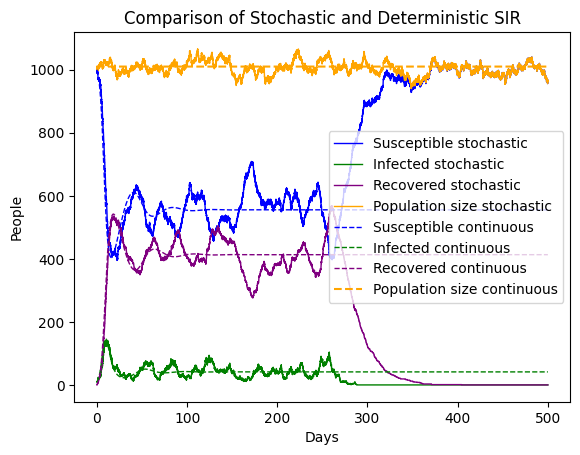

In [47]:
# Initial values SIR model
initial_SIR = [1000, 10, 0]
beta = 1
gamma = 0.5
mu = 0.05
tmax = 500

# Run stochastic SIR simulation
infection = StochasticSIR(initial_SIR, beta, gamma, tmax, mu=mu)
infection.run()

# Make ax and generate plot
fig, ax = plt.subplots(1)
infection.plot(ax, label=True)

# Set tmax to highest t in stochastic model
tmax = infection.t[-1]
dt = 0.1

# Run continuous SIR simulation
continuous_infection = ContinuousSIR(initial_SIR, tmax, dt, beta, gamma, mu)
continuous_infection.run()
continuous_infection.plot(ax)

# Compare outcomes of different approaches
plt.title("Comparison of Stochastic and Deterministic SIR")
plt.legend()
plt.xlabel('Days')
plt.ylabel('People')
plt.savefig("StochasticVsDeterministic")
plt.show()

In [24]:
class Analyze:
    def __init__(self, N, tmax, initial_SIR, beta, gamma, dt = 0.001, mu = 0):
        self.N = N
        self.N_timesteps = int(tmax / dt)
        self.t = [i * dt for i in range(self.N_timesteps - 1)]
        self.results = {'S': {i: [0 for j in range(N)] for i in self.t},
                        'I': {i: [0 for j in range(N)] for i in self.t},
                        'R': {i: [0 for j in range(N)] for i in self.t}}
        
        self.average = []
        self.std = []
        self.initial_SIR = initial_SIR
        self.gamma = gamma
        self.beta = beta
        self.tmax = tmax
        self.mu = mu

    def convert_regular_timesteps(self):
        """
        Convert stochastic SIR simulation results with irregular timesteps to regular timesteps.

        This function performs N runs of a stochastic SIR simulation and converts the resulting
        irregularly sampled data to a set of regular timesteps. It extracts the dynamics of
        susceptible (S), infected (I), and recovered (R) individuals and stores them in the
        'results' attribute of the calling object.
        """ 

        # Perform N runs
        for run in range(self.N):

            # Run stochastic SIR simulation
            infection = StochasticSIR(self.initial_SIR, self.beta, self.gamma, self.tmax, self.mu)
            infection.run()

            # Extract dynamics
            stocastic_SIR = infection.SIR
            stochastic_t = infection.t
            
            self.results['S'][0][run] = stocastic_SIR['S'][0]
            self.results['I'][0][run] = stocastic_SIR['I'][0]
            self.results['R'][0][run] = stocastic_SIR['R'][0]

            # Set initial values for stochastic timestep
            t_index = 1
            next_stochastic_t = stochastic_t[t_index]

            previous_t = self.t[0]
            
            # For each timestep
            for current_t in self.t:

                # If current timestep is before the next timestep of the stochastic SIR simulation
                if current_t < next_stochastic_t:

                    self.results['S'][current_t][run] = self.results['S'][previous_t][run]
                    self.results['I'][current_t][run] = self.results['I'][previous_t][run]
                    self.results['R'][current_t][run] = self.results['R'][previous_t][run]

                # If current timestep is after the next timestep of the stochastic SIR simulation
                else:

                    self.results['S'][current_t][run] = stocastic_SIR['S'][t_index]
                    self.results['I'][current_t][run] = stocastic_SIR['I'][t_index]
                    self.results['R'][current_t][run] = stocastic_SIR['R'][t_index]

                    # Increase stochastic time index and next timestep
                    t_index += 1
                    next_stochastic_t = stochastic_t[t_index]

                    previous_t = current_t
                    
    def get_average(self):
        return {'S': np.array([np.mean(self.results['S'][i]) for i in self.t]),
                'I': np.array([np.mean(self.results['I'][i]) for i in self.t]),
                'R': np.array([np.mean(self.results['R'][i]) for i in self.t])}
    
    def get_std(self):
        return {'S': np.array([np.std(self.results['S'][i]) for i in self.t]),
                'I': np.array([np.std(self.results['I'][i]) for i in self.t]),
                'R': np.array([np.std(self.results['R'][i]) for i in self.t])}
    
    def get_covariance(self):
        # Calculate the corvariance between S and I
        if len(self.average) == 0:
            self.average = self.get_average()

        covariance = []
        for index, i in enumerate(self.t):
            covariance.append(np.sum([(self.results['S'][i][j] - self.average['S'][index]) * (self.results['I'][i][j] - self.average['I'][index]) for j in range(self.N)]) / (self.N - 1))
        
        return covariance


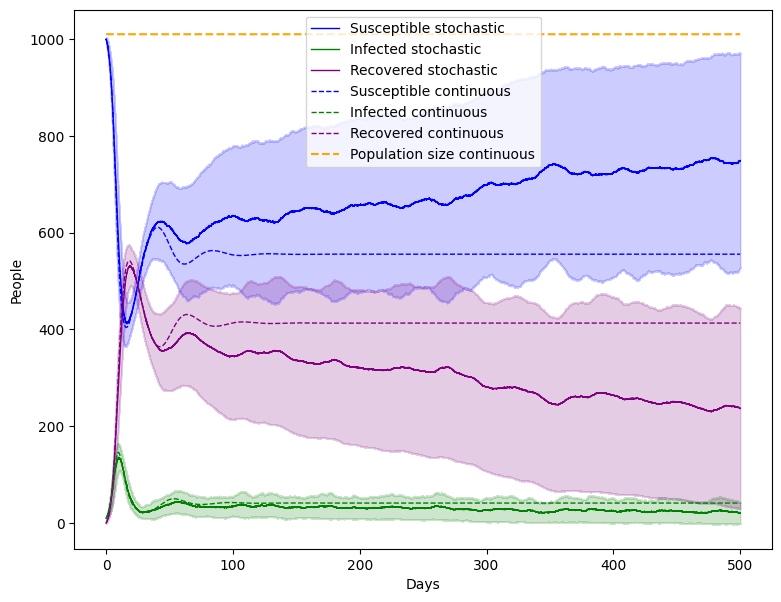

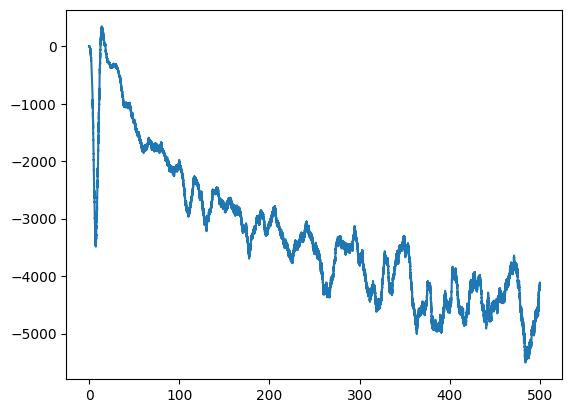

In [25]:
# Initial values SIR model
initial_SIR = [1000, 10, 0]
beta = 1
gamma = 0.5
mu = 0.05
tmax = 500
N_runs = 100

analysis = Analyze(N_runs, tmax, initial_SIR, beta, gamma, mu=mu)
analysis.convert_regular_timesteps()
average = analysis.get_average()
std = analysis.get_std()
covariance = analysis.get_covariance()
t = analysis.t

infection = StochasticSIR(initial_SIR, beta, gamma, tmax, mu=mu)
infection.SIR = average
infection.t = t

fig, ax = plt.subplots(1, figsize=(9, 7))
infection.plot(ax, std=std, N=False, label=True)

dt = 0.1

# Run continuous SIR simulation
continuous_infection = ContinuousSIR(initial_SIR, tmax, dt, beta, gamma, mu=mu)
continuous_infection.run()
continuous_infection.plot(ax)

# Compare outcomes of different approaches
plt.legend()
plt.xlabel('Days')
plt.ylabel('People')
plt.savefig("StochasticAvgVsDeterministic")
plt.show()

plt.plot(t, covariance)
plt.show()

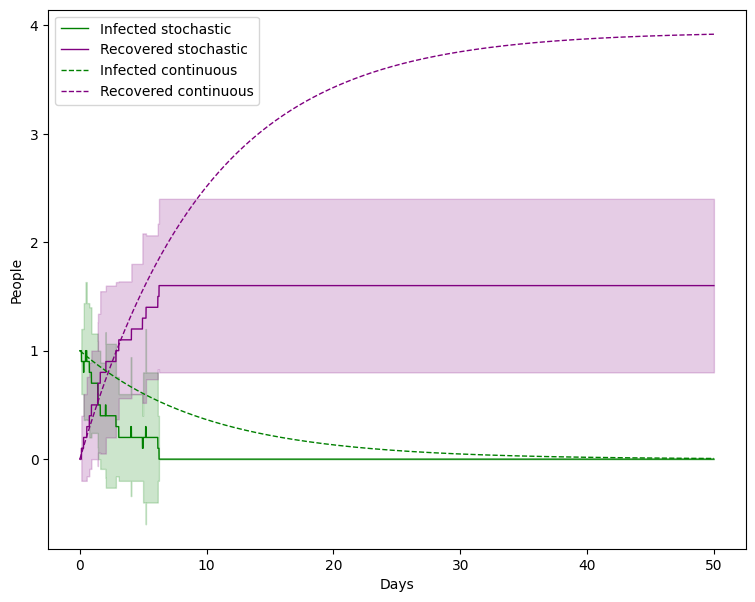

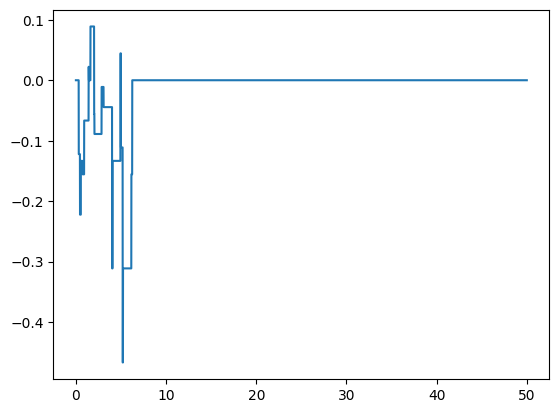

In [26]:
# Initial values SIR model
initial_SIR = [500, 1, 0]
beta = 0.3
gamma = 0.4
tmax = 50
N_runs = 10

analysis = Analyze(N_runs, tmax, initial_SIR, beta, gamma)
analysis.convert_regular_timesteps()
average = analysis.get_average()
std = analysis.get_std()
covariance = analysis.get_covariance()
t = analysis.t

infection = StochasticSIR(initial_SIR, beta, gamma, tmax)
infection.SIR = average
infection.t = t

fig, ax = plt.subplots(1, figsize=(9, 7))
infection.plot(ax, std=std, N=False, label=True, S=False)

dt = 0.1

# Run continuous SIR simulation
continuous_infection = ContinuousSIR(initial_SIR, tmax, dt, beta, gamma)
continuous_infection.run()
continuous_infection.plot(ax, S=False, N=False)

# Compare outcomes of different approaches
plt.legend()
plt.xlabel('Days')
plt.ylabel('People')
plt.show()

plt.plot(t, covariance)
plt.show()

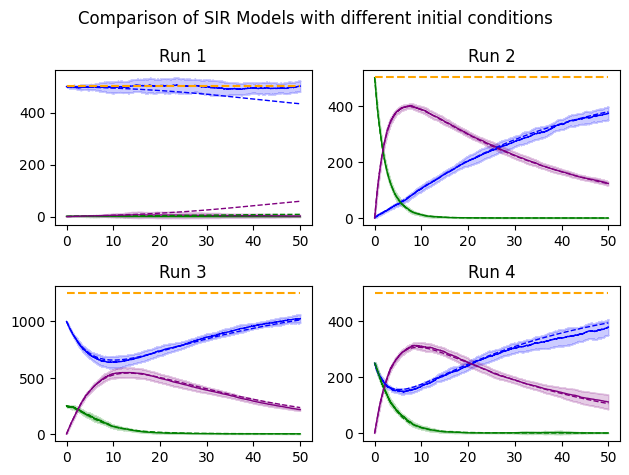

In [27]:
# Define the initial values
initial_SIR_values= [
    [500, 1, 0],
    [1, 500, 0],
    [1000, 250, 0],
    [250, 250, 0]
]
beta = 0.5
gamma = 0.4
mu = 0.03
tmax = 50
N_runs = 10

for i in range(len(initial_SIR_values)):
    initial_SIR =initial_SIR_values[i]
    analysis = Analyze(N_runs, tmax, initial_SIR, beta, gamma, mu=mu)
    analysis.convert_regular_timesteps()
    average = analysis.get_average()
    std = analysis.get_std()
    covariance = analysis.get_covariance()
    t = analysis.t

    infection = StochasticSIR(initial_SIR, beta, gamma, tmax, mu=mu)
    infection.SIR = average
    infection.t = t
    continuous_infection = ContinuousSIR(initial_SIR, tmax, dt, beta, gamma, mu=mu)
    continuous_infection.run()
    
    plt.subplot(2, 2, i+1)
    plt.title(f"Run {i+1}")
    infection.plot(plt.gca(), std=std, N=False, label=True)
    continuous_infection.plot(plt.gca())

# Compare outcomes of different initial conditions
plt.suptitle("Comparison of SIR Models with different initial conditions")
plt.tight_layout()
plt.show()

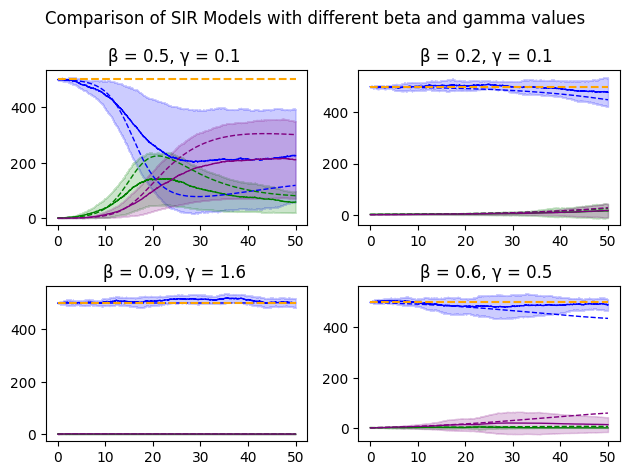

In [28]:
# Define the different initial values to compare
initial_SIR= [500, 1, 0]
beta_gamma = [
    [0.5, 0.1],
    [0.2, 0.1],
    [0.09, 1.6],
    [0.6, 0.5]
    ]
mu = 0.03
tmax = 50
N_runs = 10

for i in range(len(beta_gamma)):
    beta, gamma = beta_gamma[i][0], beta_gamma[i][1]
    analysis = Analyze(N_runs, tmax, initial_SIR, beta, gamma, mu=mu)
    analysis.convert_regular_timesteps()
    average = analysis.get_average()
    std = analysis.get_std()
    covariance = analysis.get_covariance()
    t = analysis.t

    infection = StochasticSIR(initial_SIR, beta, gamma, tmax, mu=mu)
    infection.SIR = average
    infection.t = t
    continuous_infection = ContinuousSIR(initial_SIR, tmax, dt, beta, gamma, mu=mu)
    continuous_infection.run()
    
    plt.subplot(2, 2, i+1)
    plt.title(f"β = {beta}, γ = {gamma} ")
    infection.plot(plt.gca(), std=std, N=False, label=True)
    continuous_infection.plot(plt.gca())

# Compare outcomes of different runs
plt.suptitle("Comparison of SIR Models with different beta and gamma values")
plt.tight_layout()
plt.show()

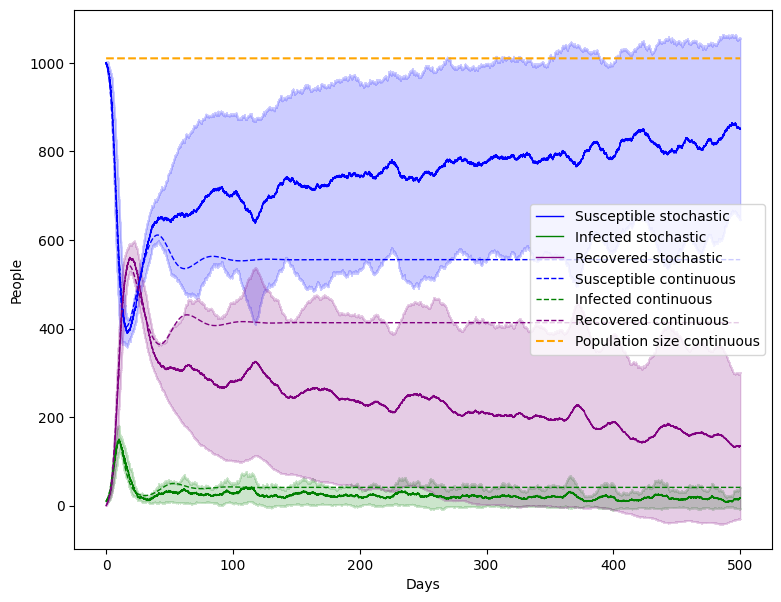

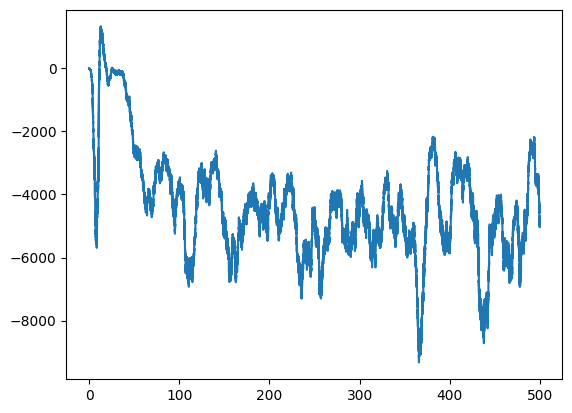

In [29]:
# Initial values SIR model
initial_SIR = [1000, 10, 0]
beta = 1
gamma = 0.5
mu = 0.05
tmax = 500
N_runs = 10

analysis = Analyze(N_runs, tmax, initial_SIR, beta, gamma, mu=mu)
analysis.convert_regular_timesteps()
average = analysis.get_average()
std = analysis.get_std()
covariance = analysis.get_covariance()
t = analysis.t

infection = StochasticSIR(initial_SIR, beta, gamma, tmax, mu=mu)
infection.SIR = average
infection.t = t

fig, ax = plt.subplots(1, figsize=(9, 7))
infection.plot(ax, std=std, N=False, label=True)

dt = 0.1

# Run continuous SIR simulation
continuous_infection = ContinuousSIR(initial_SIR, tmax, dt, beta, gamma, mu=mu)
continuous_infection.run()
continuous_infection.plot(ax)

# Compare outcomes of different approaches
plt.legend()
plt.xlabel('Days')
plt.ylabel('People')
plt.show()

plt.plot(t, covariance)
plt.show()

In [30]:
def get_extinction_duration(N, R, N_runs, variable_parameter='gamma'):
    # Initial values SIR model
    initial_SIR = [int(N  * 0.95), int(N * 0.05), 0]
    tmax = 500
    if variable_parameter == 'gamma':
        beta = 1
        mu = 0.05
        gamma = (beta / R) - mu
    elif variable_parameter == 'beta':
        gamma = 1
        mu = 0.05
        beta = R * (gamma + mu)



    extinction_t = 0
    for run in range(N_runs):
        infection = StochasticSIR(initial_SIR, beta, gamma, tmax, mu=mu)
        infection.run()
        t = infection.t
        extinction_t +=  next((i for index, i in enumerate(t) if infection.SIR['I'][index] == 0), tmax) / N_runs
    return extinction_t

In [31]:
# Define the range for N and R
N_min, N_max = 20, 2000
R_min, R_max = 0.01, 3
N_runs = 1

# Create a coarser grid for N and R values
N_values = np.linspace(N_min, N_max, 4)
R_values = np.linspace(R_min, R_max, 4)

p_coarse = []
for R in R_values:
    ps = []
    for N in N_values:
        ps.append(get_extinction_duration(N, R, N_runs, variable_parameter='gamma'))
    p_coarse.append(ps)

C:\Users\jaspe\AppData\Local\Temp\ipykernel_17768\3496919061.py:2: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  interp_func = interpolate.interp2d(N_values, R_values, p_coarse, kind='linear')
C:\Users\jaspe\AppData\Local\Temp\ipykernel_17768\3496919061.py:9: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bis

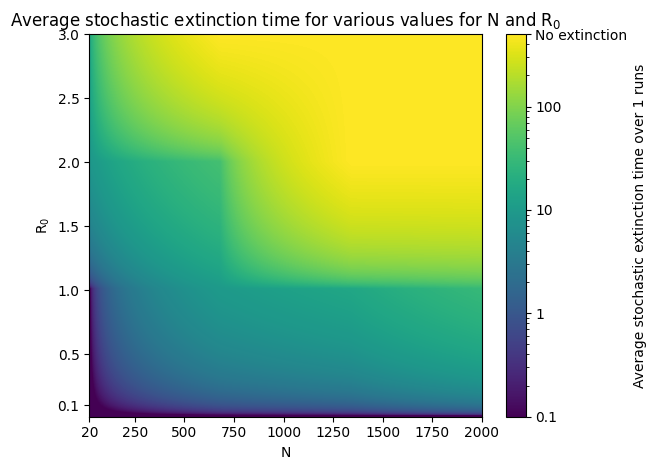

In [32]:
# Create an interpolation function using the coarser grid and p values
interp_func = interpolate.interp2d(N_values, R_values, p_coarse, kind='linear')

# Define a higher-resolution grid
N_values_fine = np.linspace(N_min, N_max, 1000)
R_values_fine = np.linspace(0, R_max, 1000)

# Interpolate p values to the fine grid
p_fine = interp_func(N_values_fine, R_values_fine)

# Create the imshow plot using the high-resolution p values
plt.imshow(p_fine, origin='lower',  extent=[N_min, N_max, R_min, R_max], aspect='auto', norm=LogNorm(0.1, 500))

colorbar = plt.colorbar(label=f'Average stochastic extinction time over {N_runs} runs')
colorbar.set_ticks([0.1, 1, 10, 100, 500])
colorbar.set_ticklabels(['0.1', '1', '10', '100', 'No extinction'])

plt.xlabel('N')
plt.ylabel(r'R$_0$')
plt.xticks([20, 250, 500, 750, 1000, 1250, 1500, 1750, 2000])
plt.yticks([0.1, 0.5, 1, 1.5, 2, 2.5, 3])
plt.title(r'Average stochastic extinction time for various values for N and R$_0$')
plt.tight_layout()
plt.show()

In [33]:
variable_parameter='beta'
p_coarse = []
for R in R_values:
    ps = []
    for N in N_values:
        ps.append(get_extinction_duration(N, R, N_runs, variable_parameter))
    p_coarse.append(ps)

C:\Users\jaspe\AppData\Local\Temp\ipykernel_17768\11629455.py:2: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://gist.github.com/ev-br/8544371b40f414b7eaf3fe6217209bff`

  interp_func = interpolate.interp2d(N_values, R_values, p_coarse, kind='linear')
C:\Users\jaspe\AppData\Local\Temp\ipykernel_17768\11629455.py:9: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.12.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplre

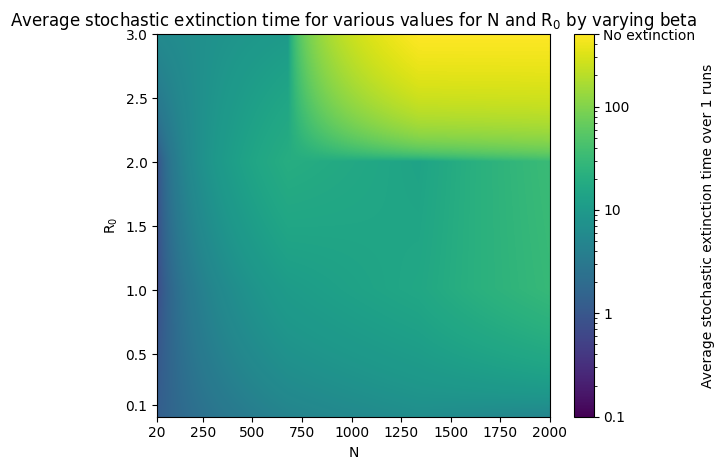

In [34]:
# Create an interpolation function using the coarser grid and p values
interp_func = interpolate.interp2d(N_values, R_values, p_coarse, kind='linear')

# Define a higher-resolution grid
N_values_fine = np.linspace(N_min, N_max, 1000)
R_values_fine = np.linspace(0, R_max, 1000)

# Interpolate p values to the fine grid
p_fine = interp_func(N_values_fine, R_values_fine)

# Create the imshow plot using the high-resolution p values
plt.imshow(p_fine, origin='lower',  extent=[N_min, N_max, R_min, R_max], aspect='auto', norm=LogNorm(0.1, 500))

colorbar = plt.colorbar(label=f'Average stochastic extinction time over {N_runs} runs')
colorbar.set_ticks([0.1, 1, 10, 100, 500])
colorbar.set_ticklabels(['0.1', '1', '10', '100', 'No extinction'])

plt.xlabel('N')
plt.ylabel(r'R$_0$')
plt.xticks([20, 250, 500, 750, 1000, 1250, 1500, 1750, 2000])
plt.yticks([0.1, 0.5, 1, 1.5, 2, 2.5, 3])
plt.title(fr'Average stochastic extinction time for various values for N and R$_0$ by varying {variable_parameter}')
plt.tight_layout()
plt.show()

In [ ]:
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
import pandas as pd

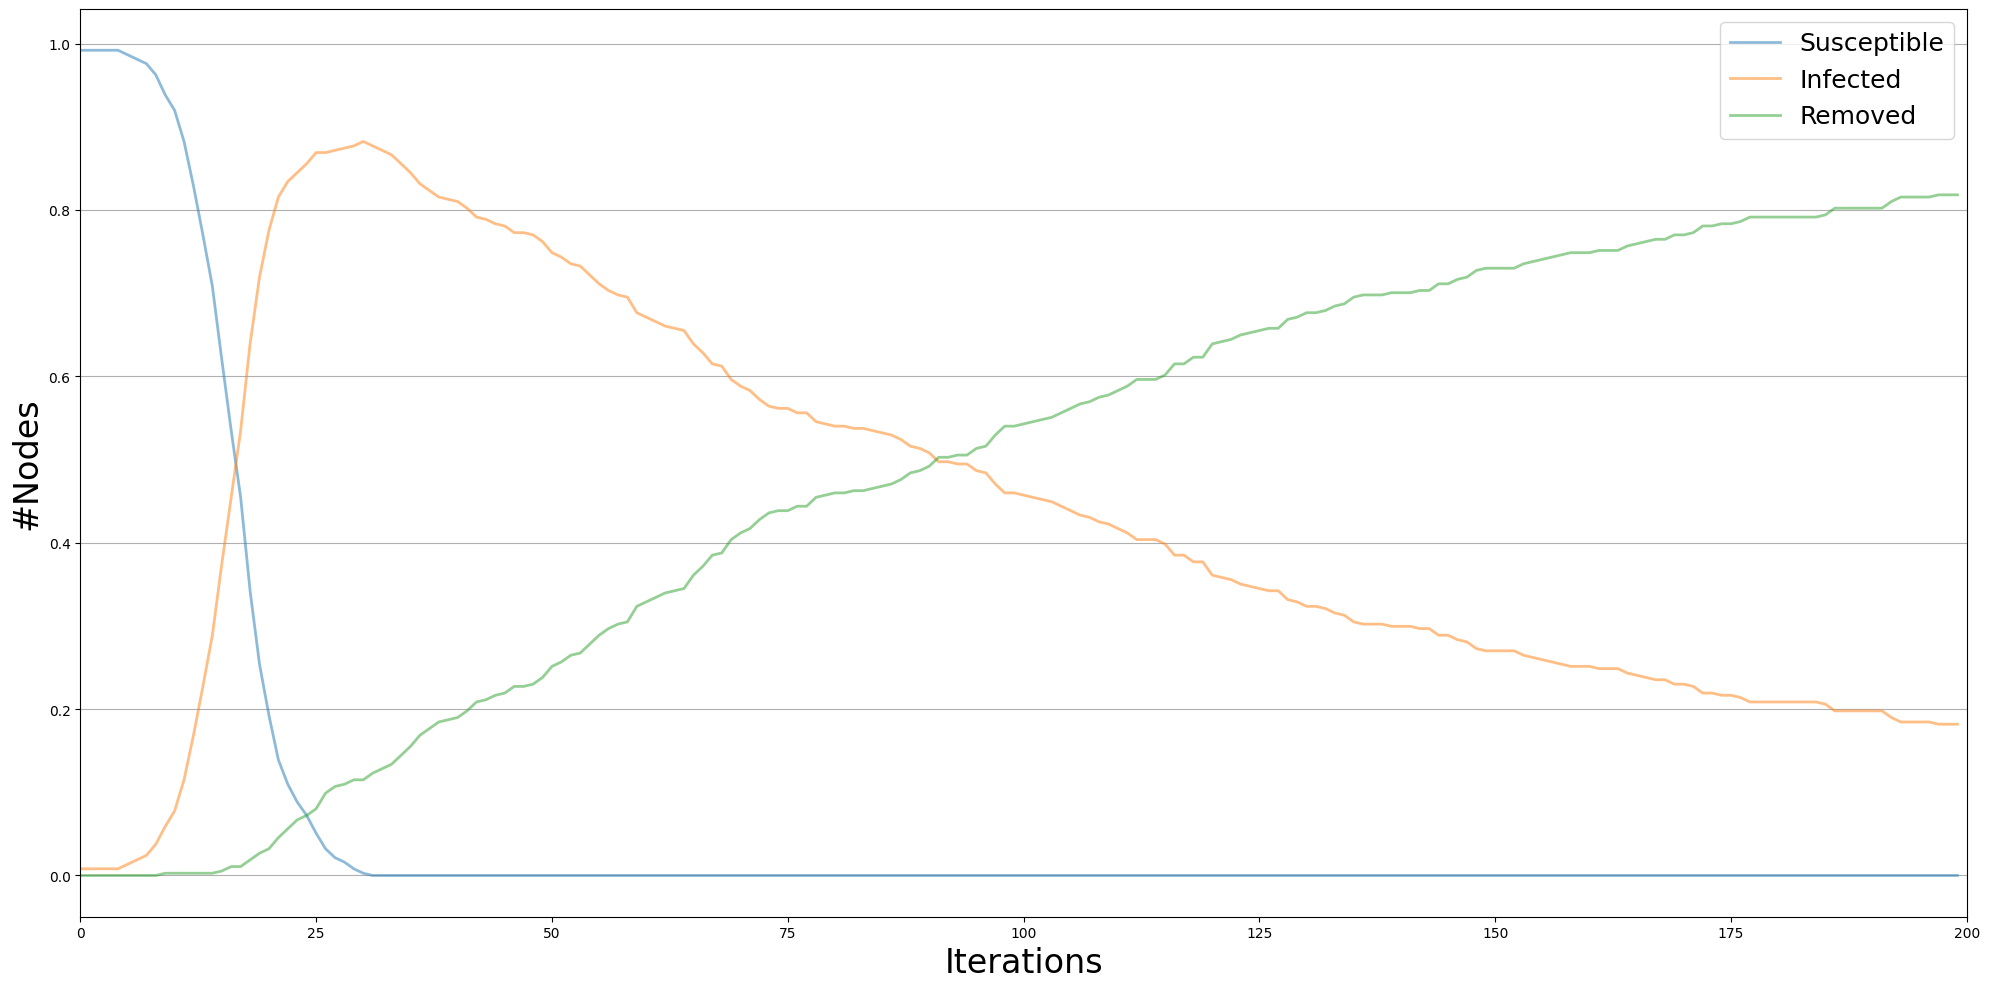

In [35]:
df = pd.read_csv('transmission_network.csv', delimiter = ';', index_col=0)

# Create the network from given external transmission network
g = nx.Graph()
for node1 in df.index:
    for node2 in df.columns:
        transmission = df.loc[node1, node2]

        if not g.has_edge(node1, node2):
            node2_int = int(node2)
            g.add_edge(node1, node2_int, transmission_rate=transmission)

# Set model parameters
model = ep.SIRModel(g)
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.001) 
cfg.add_model_parameter('gamma', 0.01) 
cfg.add_model_parameter("percentage_infected", 0.01)
model.set_initial_status(cfg)

#Perform simulation 
iterations = model.iteration_bunch(200, node_status=False)

%matplotlib inline 
trends = model.build_trends(iterations)
viz = DiffusionTrend(model, trends)
viz.plot()

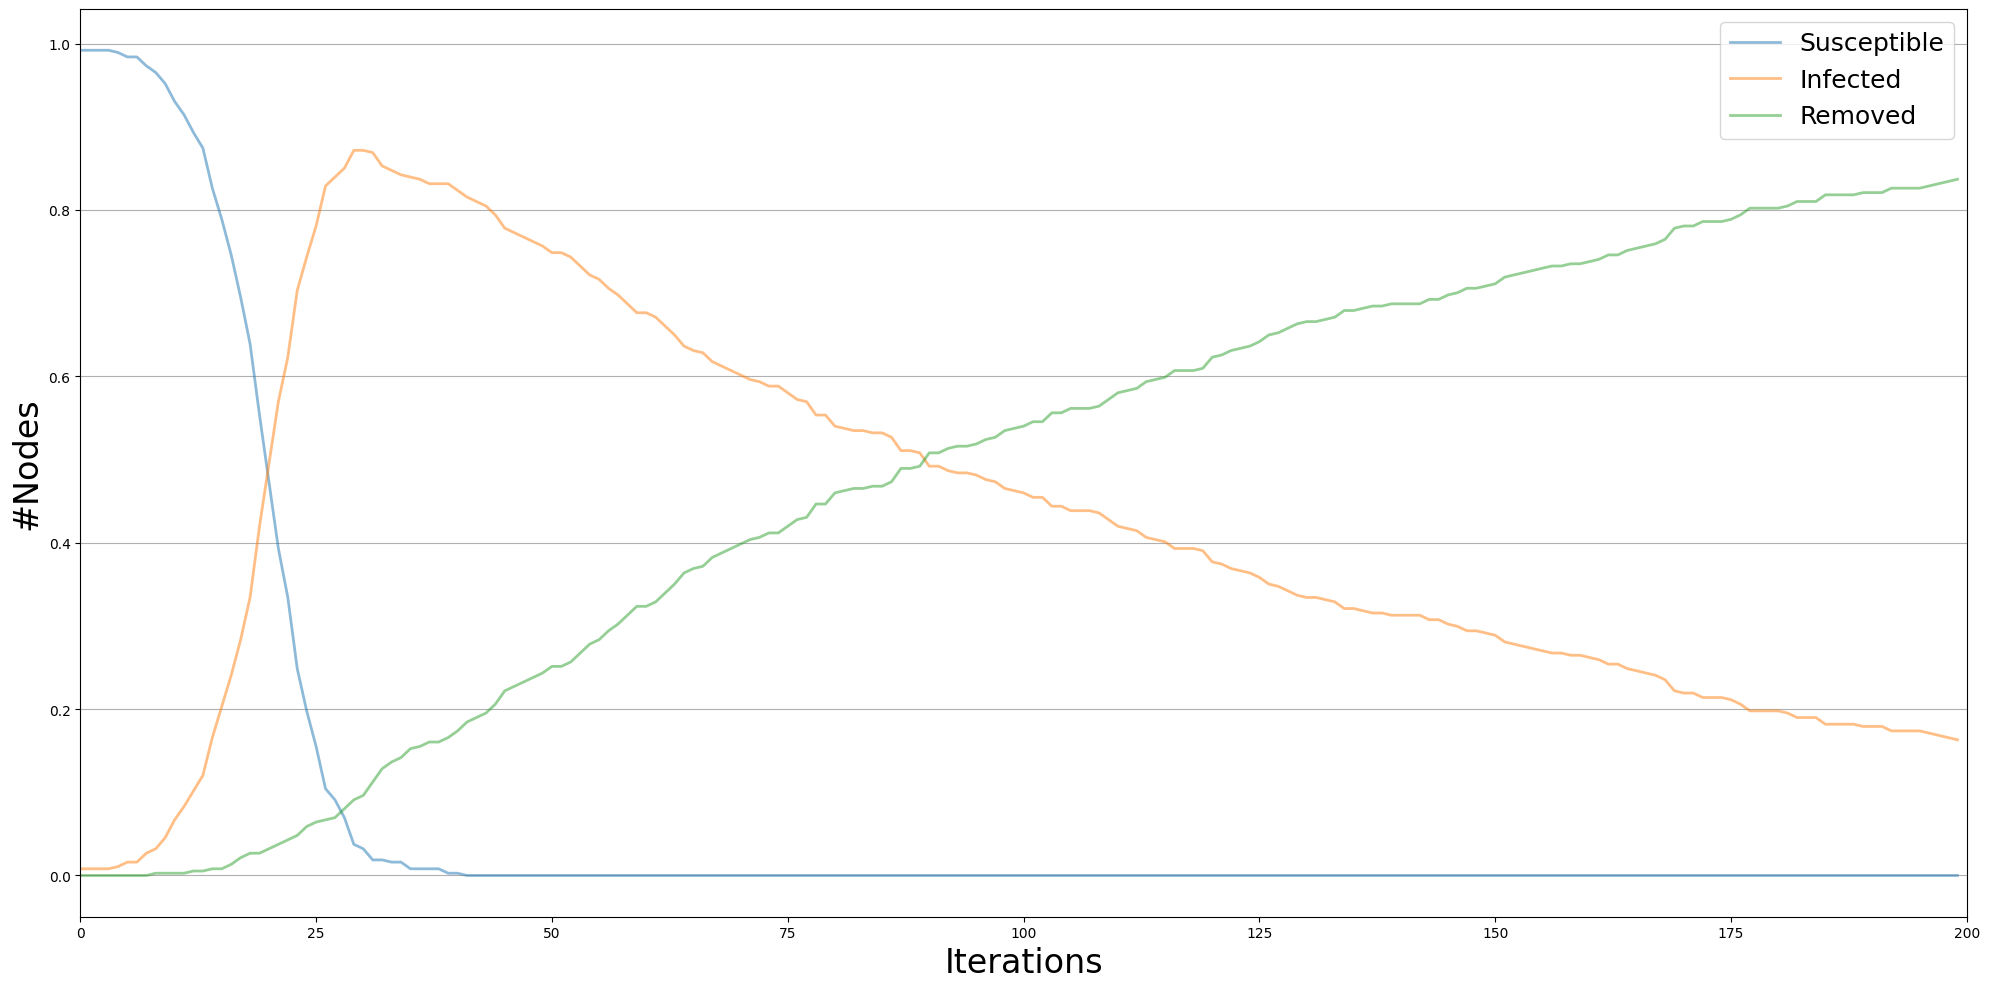

In [36]:
# Set initial parameters
model = ep.SIRModel(g)
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.001) 
cfg.add_model_parameter('gamma', 0.01) 
cfg.add_model_parameter("percentage_infected", 0.01)
model.set_initial_status(cfg)

#Perform simulation 
iterations = model.iteration_bunch(200, node_status=False)

%matplotlib inline 
trends = model.build_trends(iterations)
viz = DiffusionTrend(model, trends)
viz.plot()

In [37]:
#Generating a network
nodes = 1000
probability = 0.1
g = nx.erdos_renyi_graph(nodes, probability)

In [38]:
# Perform the simulation
